In [1]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from distributed import LocalCluster, Client
client = Client(n_workers=50,  threads_per_worker=1, processes=True, memory_limit='10 GiB')


/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42551 instead
  warnings.warn(


In [2]:

"""
testing for any difference between using OmegaConfig's parameters.yaml vs older parameters.json file
There shouldn't be any differences, but first time using OmegaConfig, so doesn't hurt to check
"""
sample = "dy_M-100To200"
# sample = "ggh_powheg"

full_load_path = f"/depot/cms/users/yun79/results/stage1/cs_varTest/2018/f1_0/{sample}/*/*.parquet"
df_dy = dak.from_parquet(full_load_path) 

# full_load_path = f"/depot/cms/users/yun79/results/stage1/yaml_test/pu_OnTheSpot/2018/f1_0/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/yaml_test/config/2018/f1_0/{sample}/*/*.parquet"
# full_load_path = f"/depot/cms/users/yun79/results/stage1/yaml_test/pu_OnTheSpot/2018/f1_0/{sample}/*/*.parquet"
full_load_path = f"/depot/cms/users/yun79/results/stage1/cs_varTest/2018/f1_0/ggh_powheg/*/*.parquet"

df_ggh = dak.from_parquet(full_load_path) 

# using pre-exisitng code for quick validation
df_new=df_dy
df_old=df_ggh

In [3]:
region = df_new.h_sidebands | df_new.h_peak | df_new.z_peak
weights_new = df_new["weights"]
weights_new = weights_new[region].compute()
# weights_new = df_new["weights"].compute()
# if "ggh" in sample:
#     print("ggh in sample!")
#     nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/0/nnlops/wgt.parquet'
#     nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
#     weights_new = weights_new*nnlops_wgts

#-------------------------------------------------------------------------
print(f"weights_new: {ak.to_numpy(weights_new)}")
print(ak.num(weights_new, axis=0))
region = df_old.h_sidebands | df_old.h_peak | df_old.z_peak
weights_old = df_old["weights"]
weights_old = weights_old[region].compute()
print(f"weights_old: {weights_old}")
print(ak.num(weights_old, axis=0))
# print(max(weights_new))
# print(min(weights_new))
# print(max(weights_old))
# print(min(weights_old))
# print(max(abs(weights_new[:]-weights_old)/weights_old))
# print(np.mean(abs(weights_new[:]-weights_old)))
# print(np.median(abs(weights_new[:]-weights_old)))
# print(max(abs(weights_new[:-3]-weights_old)/weights_old))
# print(np.mean(abs(weights_new[:-3]-weights_old)/weights_old))
# print(np.median(abs(weights_new[:-3]-weights_old)/weights_old))
# print(max(abs(weights_new-weights_old[:-3])/weights_old[:-3]))
# print(np.mean(abs(weights_new-weights_old[:-3])/weights_old[:-3]))
# print(np.median(abs(weights_new-weights_old[:-3])/weights_old[:-3]))
# print(max(abs(weights_new-weights_old)/weights_old))
# print(np.mean(abs(weights_new-weights_old)/weights_old))

weights_new: [ 0.11504793 -0.06487207  0.08104153 ... -0.0926347   0.08910227
  0.12064633]
193623
weights_old: [0.00062, 0.000688, 0.000748, 0.00062, ..., 0.000734, 0.000506, 0.000636]
622222


In [4]:
binning_map = {
    "dimuon_cos_theta_cs" : [-1, 1, 101],
    "dimuon_phi_cs" :[-3.1415, 3.1415, 101],
    # "dimuon_phi_cs" :[-5, 5, 101],
}

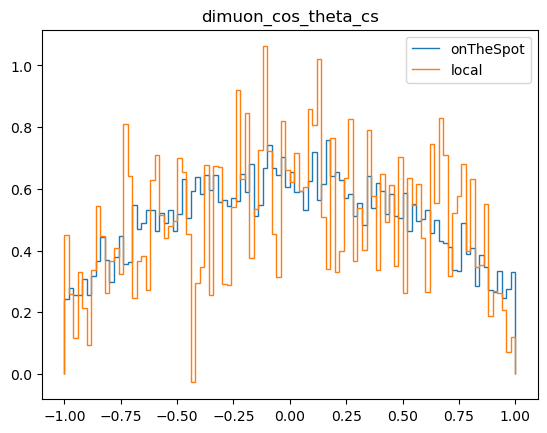

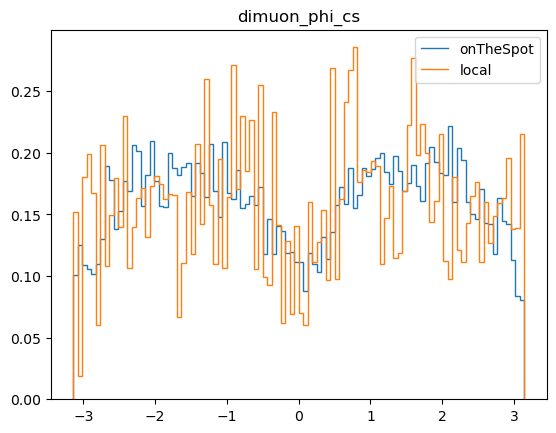

In [5]:
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["dimuon_cos_theta_cs","dimuon_phi_cs", 
            ]



# weights_new = ak.to_numpy(df_new["weights"].compute())
region = df_new.h_sidebands | df_new.h_peak | df_new.z_peak
weights_new = df_new["weights"]
btag_cut_new =(df_new["nBtagLoose"] >= 2) | (df_new["nBtagMedium"] >= 1)
weights_new = (weights_new*region * (~df_new["vbf_cut"]) * btag_cut_new).compute()


region = df_old.h_sidebands | df_old.h_peak | df_old.z_peak
weights_old = df_old["weights"]
btag_cut_old =(df_old["nBtagLoose"] >= 2) | (df_old["nBtagMedium"] >= 1)
weights_old = (weights_old*region * (~df_old["vbf_cut"]) * btag_cut_old).compute()

for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[var])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len

    var_old = var
    hist_old, edges = np.histogram(df_old[var_old].compute(), bins=binning ,weights=weights_old, density=True)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning ,weights=weights_new, density=True)
    
    plt.stairs(hist_new, edges, label = "DY")
    plt.stairs(hist_old, edges, label = "ggH")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    # plt.stairs((hist_new-hist_old), edges)
    # plt.title(var+" diff")
    # plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    # plt.show()
    # plt.stairs((hist_new-hist_old)/hist_old, edges)
    # plt.title(f"{sample} {var}"+" relative diff")
    # plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    # plt.show()